# Import list
project uses, numpy, scikit-learn, matplotlib, and pandas. The rcParams function sets the graph size

In [2]:
from operator import index

import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from mat4py import loadmat
plt.rcParams['figure.figsize'] = [15, 7]

Read the csv file and drops any non-available values. We then select a dimension of two for X and use the species as the y.

In [57]:
df = pd.read_csv("./outlierDatasets/Glass_withoutdupl_norm.csv")
df.head()

,'var_0000','var_0001','var_0002','var_0003','var_0004','var_0005','var_0006','id','outlier'
0,0.467651,0.321584,0.768880,0.246630,0.838799,0.099737,0.298340,1.0,'no'
1,0.496412,0.220491,0.776032,0.316598,0.919973,0.089145,0.279479,2.0,'no'
2,0.519133,0.404464,0.768012,0.334978,0.801622,0.092369,0.271238,3.0,'no'
3,0.199650,0.547373,0.374284,0.362223,0.817017,0.000000,0.177913,4.0,'yes'
4,0.847261,0.286361,0.000000,0.217792,0.000000,0.019135,1.000000,5.0,'no'


In [58]:
X = df.iloc[:, 0:2].values
copy_X = df.iloc[:, 2:4]
y = df.iloc[:, -1:].values

In [59]:
le = LabelEncoder()
y = le.fit_transform(y)

C:\Users\khodg\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


```main()``` chooses a nearest neighbor size and then fits X and y. After both the index of the neighbors and distances are returned. We will mainly be using the Euclidean distances.

In [60]:
def main(X,y,n):
    nn = NearestNeighbors(n_neighbors=n)
    nn.fit(X, y)
    dist, knn = nn.kneighbors(X)  # returns N index neighbors including self
    return knn, dist

knn, distReturn = main(X,y,10)

We need the total distance for each element in the list. This is done by adding all the values found in the dist array returned from the ```main()```

In [67]:
def generateArr(newDist, median=True):
    arr = []
    for x in newDist:  # finds the distance away from that point (index 0)
        if median:
            arr += [np.median(x)]
        else:
            arr += [np.max(x)]
        

    return arr

distReturn = np.array(distReturn)
arr = generateArr(distReturn)

### Equation (6)
Total distance for each index is now stored in a array so we use equation 6 from the paper to determine if the value is outside the boxplot. If so, the value is added to the outliers array

In [68]:
# equation upper = q3 + 1.5 * (q3-q2)
# equation lower = q1 - 1.5 * (q2-q1)
def boxplot(distO,X):
        outliers = []
        indexOutliers = []
        percent = np.quantile(distO, [.25, .50, .75])

        upperL = percent[2] + 1.5 * (percent[1] - percent[0])
        lowerL = percent[0] - 1.5 * (percent[2] - percent[1])

        for x in range(distO.shape[0]):
            if distO[x] > upperL:
                outliers += [X[x]]
                indexOutliers += [x]
            elif distO[x] < lowerL:
                outliers += [X[x]]
                indexOutliers += [x]
        
        return outliers, indexOutliers

arr = np.array(arr)
outliers, indexOutliers = boxplot(arr,X)

```printer()```
transforms the outliers into a numpy array and then plots them against the two X dimensions. y is used to show each color of species. Green is the outlier color

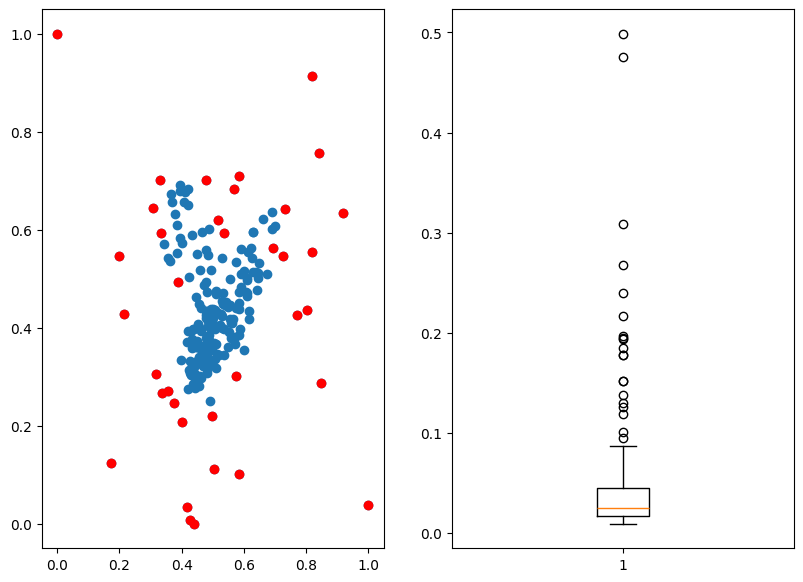

In [69]:
def printer(distO,X,y,outliers):
    outliers = np.array(outliers)
    plt.subplot(1, 3, 1)
    plt.scatter(X[:, 0], X[:, 1])
    plt.scatter(outliers[:, 0], outliers[:, 1], c="red")
    plt.subplot(1, 3, 2)
    #plt.hist(self.X[:,0],bins=15)
    plt.boxplot(distO, vert=True)
    plt.show()

printer(arr,X,y,outliers)

# Percent Correct

In [70]:
TruePositive = 0
FalsePositive = 0
indexOutliers = np.array(indexOutliers)
print(indexOutliers.size)
trueIndex = []
for x in indexOutliers:
    if y[x] == 1:
        TruePositive += 1
        trueIndex.append(x)
    if y[x] == 0:
        FalsePositive += 1
        
trueIndex = np.array(X[trueIndex])
print(TruePositive, FalsePositive,(TruePositive / indexOutliers.size), (FalsePositive / indexOutliers.size))

36
5 31 0.1388888888888889 0.8611111111111112


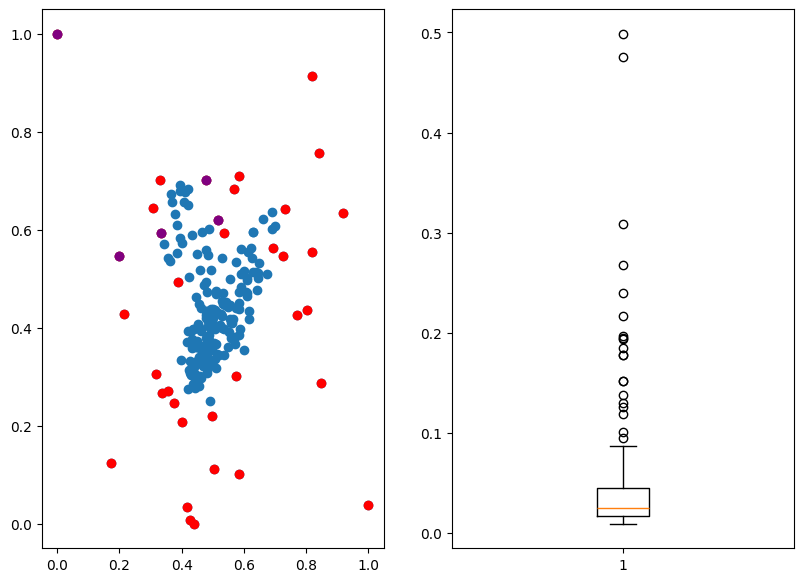

In [71]:
def printerPerc(distO,X,y,outliers):
    outliers = np.array(outliers)
    plt.subplot(1, 3, 1)
    plt.scatter(X[:, 0], X[:, 1])
    plt.scatter(outliers[:, 0], outliers[:, 1], c="red")
    plt.scatter(trueIndex[:, 0], trueIndex[:, 1], c="purple")
    plt.subplot(1, 3, 2)
    #plt.hist(self.X[:,0],bins=15)
    plt.boxplot(distO, vert=True)
    plt.show()

printerPerc(arr,X,y,outliers)

### Equation (7a)
Equation 7a follows a similar path as equation 6 other than the difference in upper and lower bounds. We use the variances of distances bigger than Q3 and less than Q1

In [66]:
def boxplot7a(distO,X):
        outliers = []
        distO = np.array(distO)
        percent = np.quantile(distO, [.25, .50, .75])

        zU = np.sqrt(np.var(distO[distO >= percent[2]]))
        zL = np.sqrt(np.var(distO[distO <= percent[0]]))
        
        upperL = percent[2] + 1.5 * zU
        lowerL = percent[0] - 1.5 * zL

        for x in range(distO.shape[0]):
            if distO[x] > upperL:
                outliers += [X[x]]
            elif distO[x] < lowerL:
                outliers += [X[x]]
        
        return outliers


outliers = boxplot7a(arr,X)

After running equation 7a, we map it to a graph and show the outliers as green

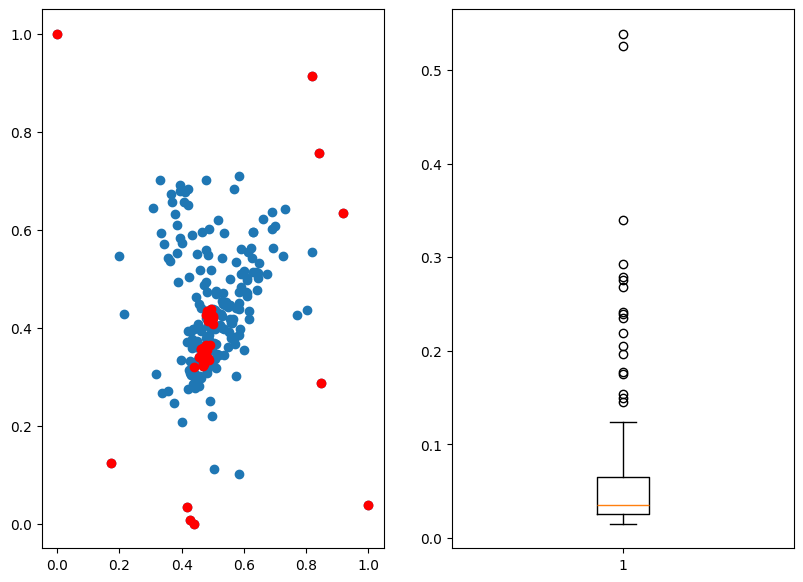

In [37]:
def printer7a(distO,X,y,outliers):
    outliers = np.array(outliers)
    plt.subplot(1, 3, 1)
    plt.scatter(X[:, 0], X[:, 1])
    plt.scatter(outliers[:, 0], outliers[:, 1], c="red")
    plt.subplot(1, 3, 2)
    #plt.hist(self.X[:,0],bins=15)
    plt.boxplot(distO, vert=True)
    plt.show()
    
printer7a(arr,X,y,outliers)